# 데이터 로드 

Data
├ Water Data

│ ├ data_2012.csv

│   ├ ymdhm : 년월일시분

│   ├ swl : 팔당댐 현재수위 (단위: El.m)

│   ├ inf : 팔당댐 유입량 (단위: m^3/s)

│   ├ sfw : 팔당댐 저수량 (단위: 만m^3)

│   ├ ecpc : 팔당댐 공용량 (단위: 백만m^3)

│   ├ tototf : 총 방류량 (단위: m^3/s)

│   ├ tide_level : 강화대교 조위 (단위: cm)

│   ├ wl_1018662 : 청담대교 수위 (단위: cm)

│   ├ fw_1018662 : 청담대교 유량 (단위: m^3/s)

│   ├ wl_1018680 : 잠수교 수위 (단위: cm)

│   ├ fw_1018680 : 잠수교 유량 (단위: m^3/s)

│   ├ wl_1018683 : 한강대교 수위 (단위: cm)

│   ├ fw_1018683 : 한강대교 유량 (단위: m^3/s)

│   ├ wl_1019630 : 행주대교 수위 (단위: cm)

│   └ fw_1019630 : 행주대교 유량 (단위: m^3/s)

│ ├ data_2013.csv

…

└ └ data_2022.csv

└ RainFall Data

│ ├ rf_2012.csv

│   ├ YMDHM : 년월일시분

│   ├ rf_10184100 : 대곡교 강수량

│   ├ rf_10184110 : 진관교 강수량

│   └ rf_10184140 : 송정동 강수량

│ ├ rf_2013.csv

…

└ └ rf_2022.csv

In [1]:
%cd Dacon_paldang

/data/Dacon_paldang


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os 

from glob import glob
from tqdm import tqdm
from scipy import interpolate
from DataGenerator import DataGenerator

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

In [3]:
def load_files(fold_dir):
    file_dirs = sorted(glob(f'{fold_dir}/*'))
    df = pd.read_csv(file_dirs[0])
    for i in range(1,len(file_dirs)):
        temp_df = pd.read_csv(file_dirs[i])
        df = pd.concat([df,temp_df])
    df = df.reset_index(drop=True)
    return df 

def preprocess_df(df):
    #컬럼 설정 
    #제외 컬럼 : 'fw_1018680'
    columns = ['ymdhm','swl','inf','sfw','ecpc','tototf','tide_level','fw_1018662','fw_1018683','rf_10184100','rf_10184110','rf_10184140','wl_1018662','wl_1018680','wl_1018683','wl_1019630']
    df = df[columns]
    #결측치 설정 
    df = df.fillna(method="ffill")
    #데이트타임 
    df['ymdhm'] = pd.to_datetime(df['ymdhm'])
    #test 데이터 범위 제외 
    df = df.iloc[:-6912]
    return df 
    

def load_df():
    water = load_files('water_data')
    rf = load_files('rf_data')
    
    df = pd.concat([water,rf.drop(columns='ymdhm')],axis=1)
    df = preprocess_df(df)
    return df 

def scailng_df(df):
    timestamps = df['ymdhm']
    min_value = np.min(df,axis=0)
    max_value = np.max(df,axis=0)
    
    scalied_df = (df-min_value)/(max_value-min_value)
    
    scalied_df['ymdhm'] = timestamps
    scaling_value = {'min' : min_value,
                     'max' : max_value
                    }
    
    return scalied_df,scaling_value 

#df 생성 및 전처리 
os.chdir('/data/Dacon_paldang/data')
df = load_df()
df,scaling_value = scailng_df(df)

#키값(타임스탬프) 생성 
timestamps = df['ymdhm'].to_numpy()[30:]

#input - output column 
input_columns = ['swl','inf','sfw','ecpc','tototf','tide_level','fw_1018662','fw_1018683','wl_1019630','rf_10184100','rf_10184110','rf_10184140']
output_columns = ['wl_1018662','wl_1018680','wl_1018683','wl_1019630']

#하이퍼 파라미터 
opt = {} 
opt['batch_size'] = 32
opt['shuffle'] = True
opt['subset_length'] = 6
opt['timestamps'] = timestamps 
opt['input'] = input_columns
opt['output_columns'] = output_columns
opt['input_columns'] = input_columns 

# 모델 

In [4]:
import tensorflow as tf
from tensorflow import keras 
tf.executing_eagerly()
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization,Input,Dropout,Dense,Conv2D,Concatenate,Flatten,Conv1D,Conv2D,MaxPooling1D
from tensorflow.keras.layers import Reshape,Embedding,concatenate
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D,GlobalAveragePooling3D,AveragePooling3D,MaxPooling2D
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
n=0
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        self.logs = []
        self.fig = plt.figure()


    def on_epoch_end(self, epoch, logs={}):
        global n,airport

        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
        

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    f'../save_model/',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


callbacks = [ plot_losses,model_check_point]

In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res 

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(4, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

scheduler = optimizers.schedules.CosineDecay(initial_learning_rate=0.0005,decay_steps=1000,alpha=0.9)
    
optimizer = optimizers.Adam(learning_rate=scheduler)

input_shape = (opt['subset_length'],12)
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss=root_mean_squared_error,
    optimizer=optimizer,
    metrics=["mse"],
    )

2022-08-03 06:28:44.723844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 06:28:44.729468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 06:28:44.729901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 06:28:44.730528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

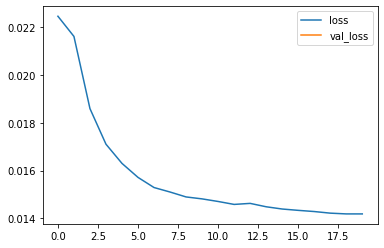

loss =  0.014182834886014462 , val_loss =  None
2105/2105 [==============================] - 19s 9ms/step - loss: 0.0142 - mse: 2.0594e-04


In [9]:
opt['batch_size'] = 128

train_generator= DataGenerator(opt,df)
model.fit(train_generator,epochs=20,verbose=1,callbacks = callbacks)

# 테스트 

In [15]:
def load_test_df():
    water = load_files('water_data')
    rf = load_files('rf_data')
    test_df = pd.concat([water,rf.drop(columns='ymdhm')],axis=1)
    test_df = preprocess_test_df(test_df)
    return test_df 

def preprocess_test_df(df):
    #컬럼 설정 
    #제외 컬럼 : 'fw_1018680'
    columns = ['ymdhm','swl','inf','sfw','ecpc','tototf','tide_level','fw_1018662','fw_1018683','rf_10184100','rf_10184110','rf_10184140','wl_1018662','wl_1018680','wl_1018683','wl_1019630']
    df = df[columns]
    #결측치 설정 
    df = df.fillna(method="ffill")
    #데이트타임 
    df['ymdhm'] = pd.to_datetime(df['ymdhm'])
    
    return df 

def scailng_test(test_df,scaling_value):
    min_value = scaling_value['min']
    max_value = scaling_value['max']
    timestamps = test_df['ymdhm']

    scaling_test_df = (test_df-min_value)/(max_value-min_value)
    scaling_test_df['ymdhm'] = timestamps 
    return scaling_test_df 


In [17]:
test_df = load_test_df() 
test_df = scailng_test(test_df,scaling_value)   
test_df.iloc[:,1:] = test_df.drop(columns=['ymdhm']).apply(lambda x : x.astype(np.float16)) #타입 변경 

test_opt = opt.copy()
test_opt['timestamps'] = test_df['ymdhm'][-6912:]
test_opt['shuffle']=False

## 추론 

In [20]:
test_d = DataGenerator(test_opt,test_df)
y_ = model.predict(test_d)

54/54 [==============================] - 139s 3s/step


## Post process 

In [21]:
def reverse_scaling(scaling_value,y_):
    min_value = scaling_value['min'].to_numpy()[-4:]
    max_value = scaling_value['max'].to_numpy()[-4:]
    reverse_value = y_*(max_value-min_value) + min_value 
    return reverse_value 

predicted = reverse_scaling(scaling_value,y_)
  

## submission 

In [37]:
%cd '/data/Dacon_paldang'

submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1:] = predicted
submission.to_csv('submission0805.csv',index=False)

/data/Dacon_paldang
